## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

### 1. EDA, 전처리
1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

In [155]:
pip install bayesian-optimization

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization

1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [157]:
from google.colab import drive
drive.mount('/content/gdrive')
path  = "/content/gdrive/My Drive/"
fname = "pitching.csv"
df=pd.read_csv(path + fname)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [159]:
df = df.dropna(axis=1, how='any')

1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

In [160]:
value_count = df['year'].value_counts()
print(value_count)

year
2015    809
2014    746
2009    729
2013    726
2012    722
       ... 
1872     23
1878     22
1877     19
1871     19
1874     17
Name: count, Length: 145, dtype: int64


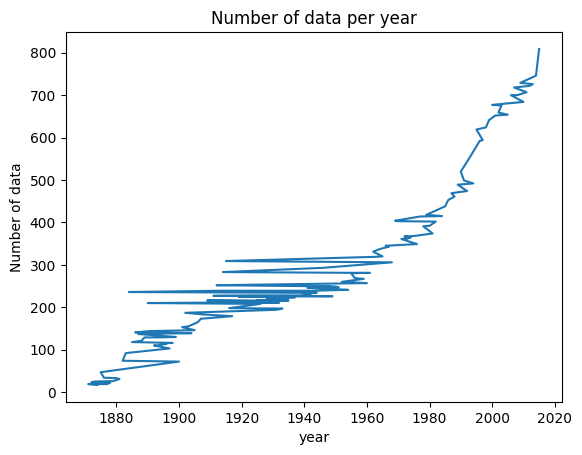

In [161]:
value_count.plot()
plt.title('Number of data per year')
plt.xlabel('year')
plt.ylabel('Number of data')
plt.show()

1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [162]:
df = df[df['year'] >= 1980]
row_count = len(df)
print(row_count)

21157


1.6 reset_index()를 통해 재배열하세요.

In [163]:
df.reset_index(drop=True, inplace=True)

1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [164]:
df['w']

0         8
1        12
2        14
3         0
4         7
         ..
21152    11
21153     0
21154    13
21155     0
21156     0
Name: w, Length: 21157, dtype: int64

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [165]:
df = df[df['w'] != 0]
df

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,3,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,3,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,5,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,1,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44


1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [166]:
df['w'] = np.where(df['w'] >= 10, 1, 0)
df

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [167]:
print(df['w'].value_counts())

w
0    12589
1     2714
Name: count, dtype: int64


1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [168]:
df = df.drop(columns=['player_id', 'year', 'team_id'])

1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [169]:
sm = SMOTE(sampling_strategy='auto', random_state = 123)
x_resampled,y_resampled = sm.fit_resample(df,df['w'])

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [170]:
print(sum(y_resampled==1),sum(y_resampled==0))

12589 12589


1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

데이터 불균형 문제를 해결하기 위해서 소수 클래스의 데이터를 합성합니다. 우선 소수의 클래스로부터 무작위로 샘플을 추출합니다. 그리고 그 샘플의 K-최근접 이웃을 찾고 그 이웃과 샘플 사이에 새로운 샘플을 만듭니다.


장점 : 단순 복제가 아니라서 다양성을 높힐 수 있고 데이터가 많아지므로 오버피팅도 예방할 수 있습니다.
단점 : 합성된 샘플은 진짜 데이터는 아니기 때문에 모델의 성능 정확도가 떨어질 수 있습니다.

1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).

- resampling은 단순히 데이터 샘플 몇개를 복제하여 데이터 수를 늘리는 방법
- Borderline-SMOTE는 보더라인 부분에서만 SMOTE를 사용하는 방법
- ADASYN은 Borderline-SMOTE와 비슷하지만 샘플링 개수를 데이터 위치에 따라 다르게 설정하는 방법

### 2. 예측 및 분석
2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(trian-60%, val-20%, test-20%).

In [171]:
train_set,test_set=train_test_split(df,test_size=0.4,random_state = 123)
val_set,test_set=train_test_split(df,test_size=0.5,random_state = 123)

2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.

validation set로 하이퍼파라미터를 수정할 수 있고 과적합을 방지할 수도 있기 때문에 validation set가 필요합니다.

2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [172]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [173]:
clf1=RandomizedSearchCV(
    estimator=accuracy_score,
    param_distributions=param_grid,
    n_iter = 500,
    cv = 5,
    scoring='accuracy',
    verbose=1,
    random_state = 123
  )

2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

- estimator: 성능지표
- param_distributions: 하이퍼파라미터 후보군을 딕셔너리 형태로 지정
- n_iter: random search 조합 탐색 횟수
- cv: 교차 검증 분할 수
- scoring: 모델 성능 평가 기준
- verbose: 진행상황 자세히 출력
- random_state: 모델이 재현 가능하게끔

2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [174]:
clf2 = GridSearchCV(
    estimator=accuracy_score,
    param_grid=param_grid,
    refit=True,
    verbose=1
)

2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

차이 : Randomized SearchCV는 무작위로 조합을 선택하는 반면 Grid SearchCV는 모든 조합을 시도해 최적의 조합을 찾습니다.
Randomized SearchCV의 장점은 빠르게 탐색한다는 것이고 단점은 무작위로 조합을 선택하기 때문에 중요한 조합을 빼먹을 수 있다는 것입니다.
Grid SearchCV의 장점은 모든 조합을 시도하기 때문에 최고의 조합을 찾을 수 있다는 것이고 단점은 하이퍼파라미터의 크기가 클 경우, 시간이 오래 걸린다는 것입니다.

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

### 3. 자유분석
최적의 파라미터 셋을 찾고 성능을 높여보세요.